In [57]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [58]:
# Importing data
timestamps = pd.read_csv('/content/timestamps1.csv')
timestamps['endTime'] = pd.to_datetime(timestamps['endTime'])
timestamps.head()

,endTime
0,2024-08-14 10:06:00
1,2024-08-14 10:08:00
2,2024-08-14 10:12:00
3,2024-08-14 10:15:00
4,2024-08-14 10:16:00


In [59]:
# Creating a column of time between timestamps
time_diffs = timestamps['endTime'].diff()
timestamps['time_diff'] = time_diffs
# Convert to seconds before filling NaN
timestamps['time_diff'] = timestamps['time_diff'].dt.total_seconds()
timestamps['time_diff'].fillna(0, inplace=True)
timestamps['time_diff'] = timestamps['time_diff'].astype(int)
timestamps.head()

<ipython-input-59-ff8292b2f402>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  timestamps['time_diff'].fillna(0, inplace=True)


,endTime,time_diff
0,2024-08-14 10:06:00,0
1,2024-08-14 10:08:00,120
2,2024-08-14 10:12:00,240
3,2024-08-14 10:15:00,180
4,2024-08-14 10:16:00,60


In [60]:
# Max and average values
largest_time_diff = timestamps['time_diff'].max()
average_time_diff = timestamps['time_diff'].mean()

print(f"Largest time difference: {largest_time_diff}")
print(f"Average time difference: {average_time_diff}")

Largest time difference: 204600
Average time difference: 816.45


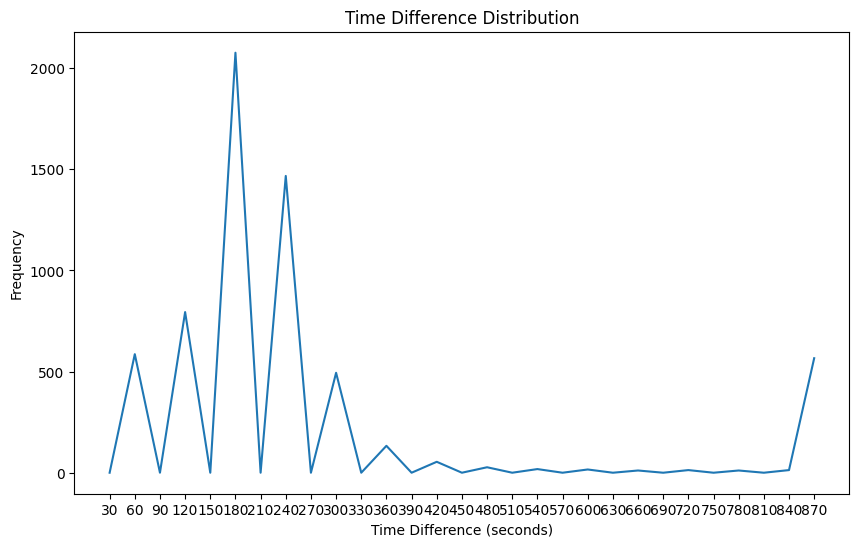

In [61]:
# The idea was to just look at the intervals between timestamps when actually using.. whatver this data is from
# and ignoring the data from gaps of days or weeks, or just overnight, to get a better idea of the shape of the data
increments = [30*i for i in range(1, 30)]
bins = increments + [np.inf]  # Add infinity to capture the largest value
time_diff_counts, _ = np.histogram(timestamps['time_diff'], bins=bins)

plt.figure(figsize=(10, 6))
plt.plot(increments, time_diff_counts)
plt.xscale('linear')
plt.xlabel("Time Difference (seconds)")
plt.ylabel("Frequency")
plt.title("Time Difference Distribution")
plt.xticks(increments, [f"{p}" for p in increments])
plt.show()

In [62]:
timestamps['date'] = timestamps['endTime'].dt.date
date_counts = timestamps.groupby('date')['endTime'].count()

# Find the date with the most timestamps
most_timestamps_date = date_counts.idxmax()
most_timestamps_count = date_counts.max()

most_timestamps_day_data = timestamps[timestamps['date'] == most_timestamps_date]
average_time_diff_on_date = most_timestamps_day_data['time_diff'].mean()


print(f"The day with the most timestamps is: {most_timestamps_date}")
print(f"Number of timestamps on that day: {most_timestamps_count}")
print(f"Average time difference between timestamps on that day: {average_time_diff_on_date} seconds.")

print(timestamps.groupby('date')['time_diff'].mean())

The day with the most timestamps is: 2024-09-19
Number of timestamps on that day: 306
Average time difference between timestamps on that day: 273.3333333333333 seconds.
date
2024-08-14     204.935065
2024-08-15     521.351351
2024-08-16     312.206897
2024-08-17     344.761905
2024-08-18     270.000000
                 ...     
2024-11-12     794.754098
2024-11-13    1120.273973
2024-11-14    2056.744186
2024-11-15    1386.666667
2024-11-16    3860.000000
Name: time_diff, Length: 93, dtype: float64


In [63]:
# Using the data from the bin sorting to exclude overnight/not using... whatever the data is from, here's the update
# average usage
def daily_average_time_diff(df):
    daily_averages = []
    for date, group in df.groupby('date'):
        filtered_diffs = group['time_diff'][group['time_diff'] <= 1000]
        if not filtered_diffs.empty:
            daily_averages.append(filtered_diffs.mean())
    return pd.Series(daily_averages, index=df.groupby('date').groups.keys())


average_diffs_per_day = daily_average_time_diff(timestamps)

print("\nAverage time difference per day (ignoring differences > 1000 seconds):")
print(average_diffs_per_day)

overall_average = average_diffs_per_day.mean()
print(f"\nOverall average of daily averages: {overall_average}")


Average time difference per day (ignoring differences > 1000 seconds):
2024-08-14    204.935065
2024-08-15    109.541284
2024-08-16    165.211268
2024-08-17    164.016393
2024-08-18    155.789474
                 ...    
2024-11-12     73.043478
2024-11-13     63.750000
2024-11-14    123.076923
2024-11-15    110.181818
2024-11-16    211.578947
Length: 93, dtype: float64

Overall average of daily averages: 121.77030914115062


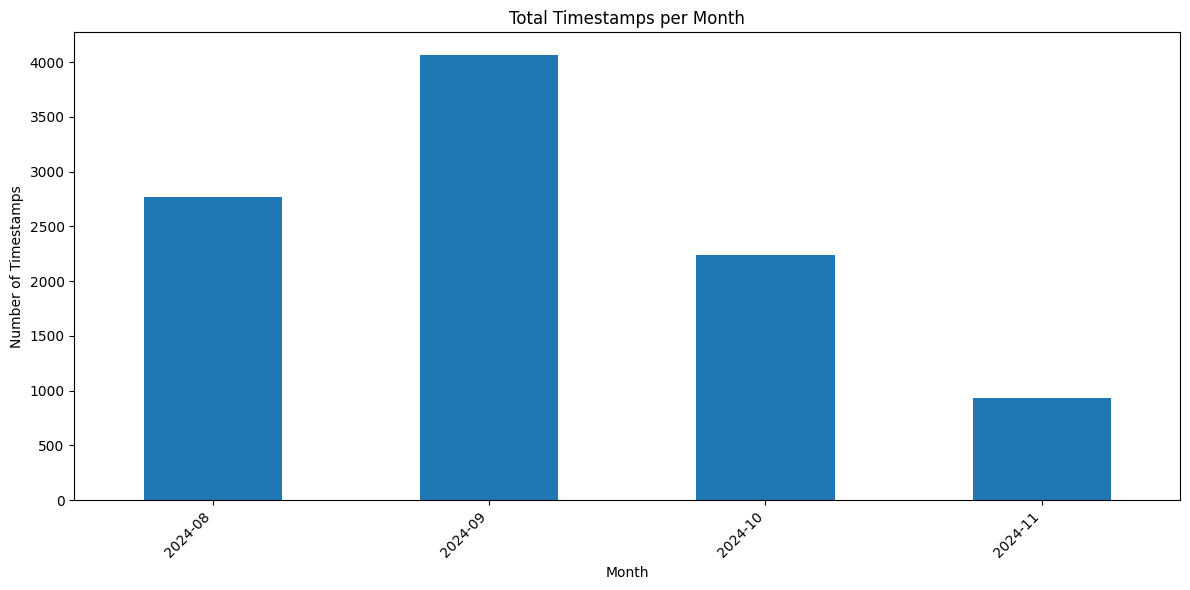

In [64]:
# Graphing total timestamps each month to look for trends - this is only a 4 month data window however so it's hard to see trends
timestamps['month_year'] = timestamps['endTime'].dt.to_period('M')
monthly_counts = timestamps.groupby('month_year')['endTime'].count()

plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar')
plt.xlabel("Month")
plt.ylabel("Number of Timestamps")
plt.title("Total Timestamps per Month")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


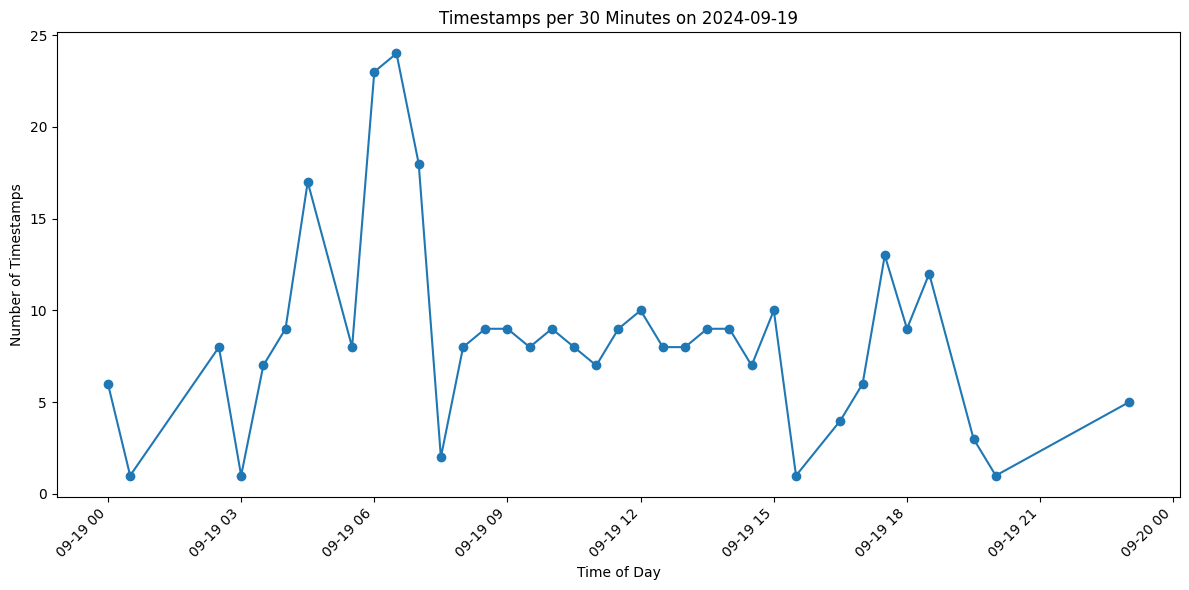

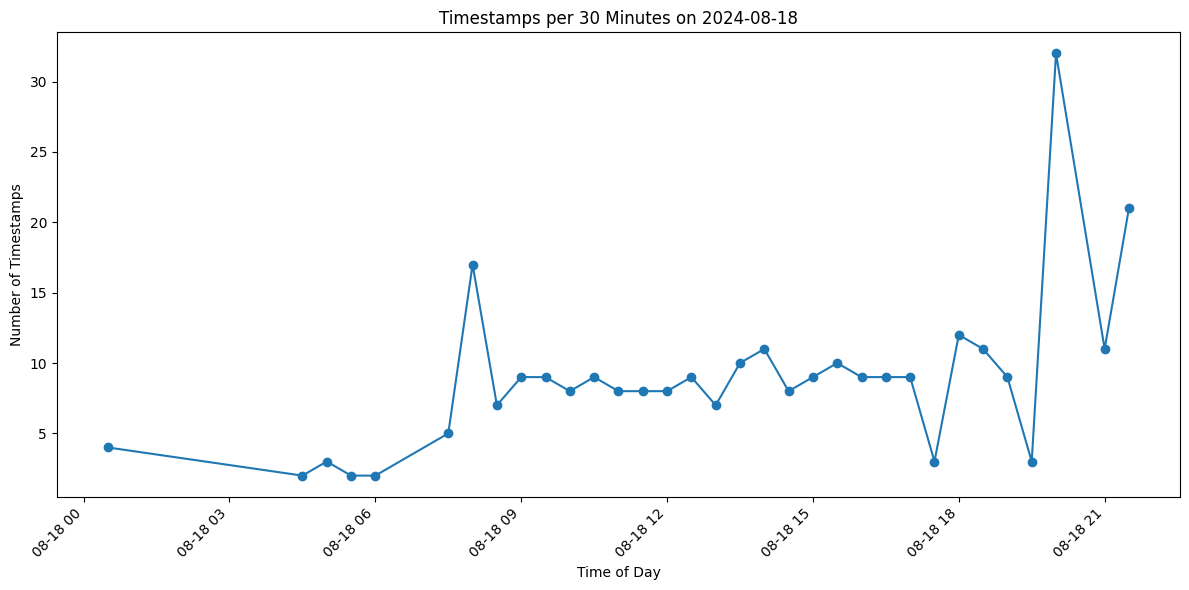

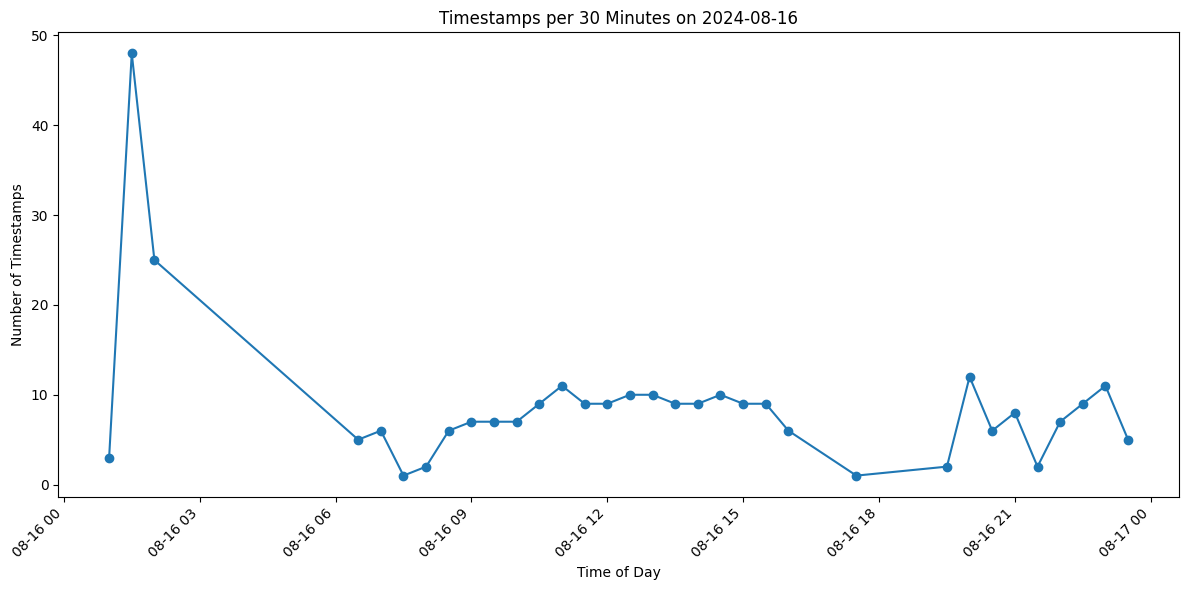

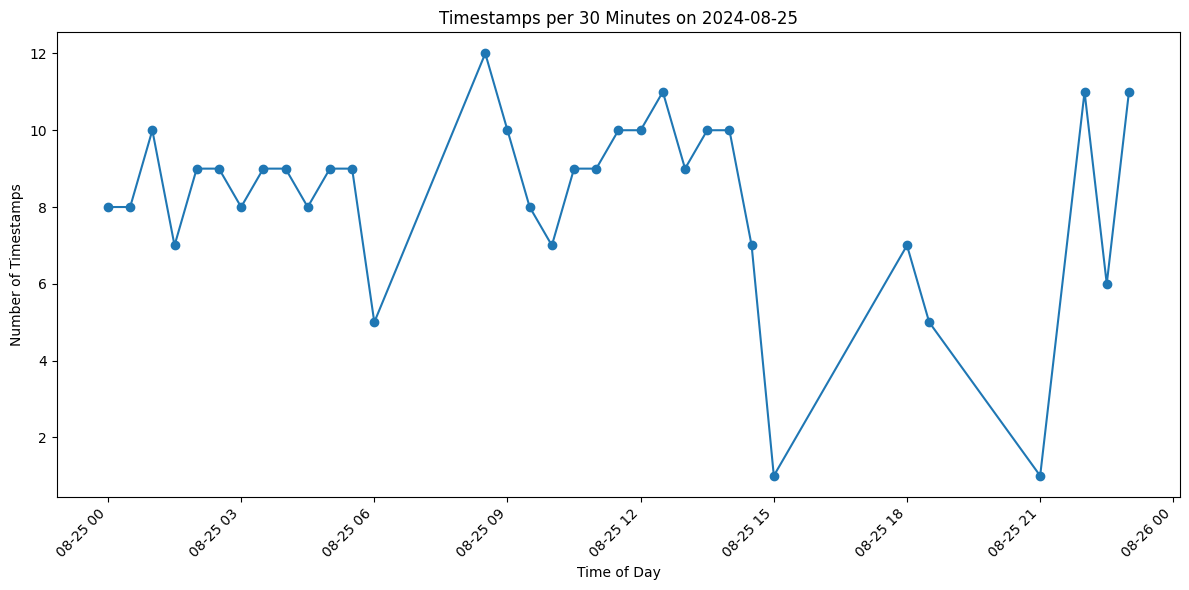

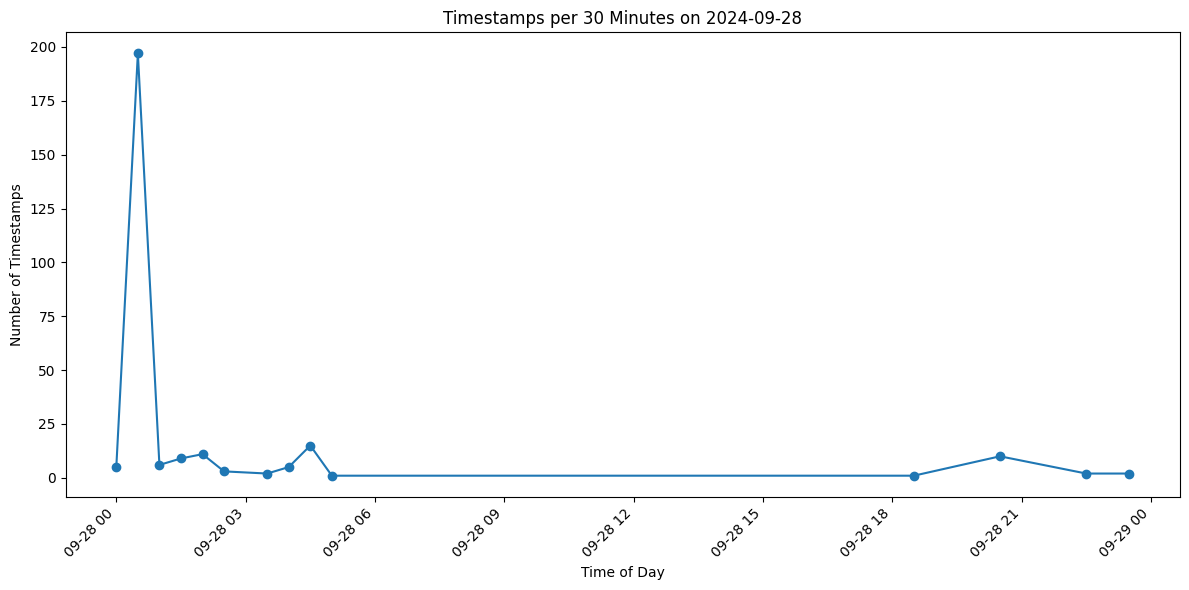

In [65]:
# Plotting the top 5 days of timestamps by timestamps per half hour to look for daily trends
def plot_timestamps_by_half_hour(timestamps_df, top_n=5):
    timestamps_df['half_hour'] = timestamps_df['endTime'].dt.floor('30min')
    daily_counts = timestamps_df.groupby(['date', 'half_hour']).size().reset_index(name='count')

    top_days = daily_counts.groupby('date')['count'].sum().sort_values(ascending=False).head(top_n).index

    for day in top_days:
        day_data = daily_counts[daily_counts['date'] == day]
        plt.figure(figsize=(12, 6))
        plt.plot(day_data['half_hour'], day_data['count'], marker='o')
        plt.xlabel('Time of Day')
        plt.ylabel('Number of Timestamps')
        plt.title(f'Timestamps per 30 Minutes on {day}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


plot_timestamps_by_half_hour(timestamps)

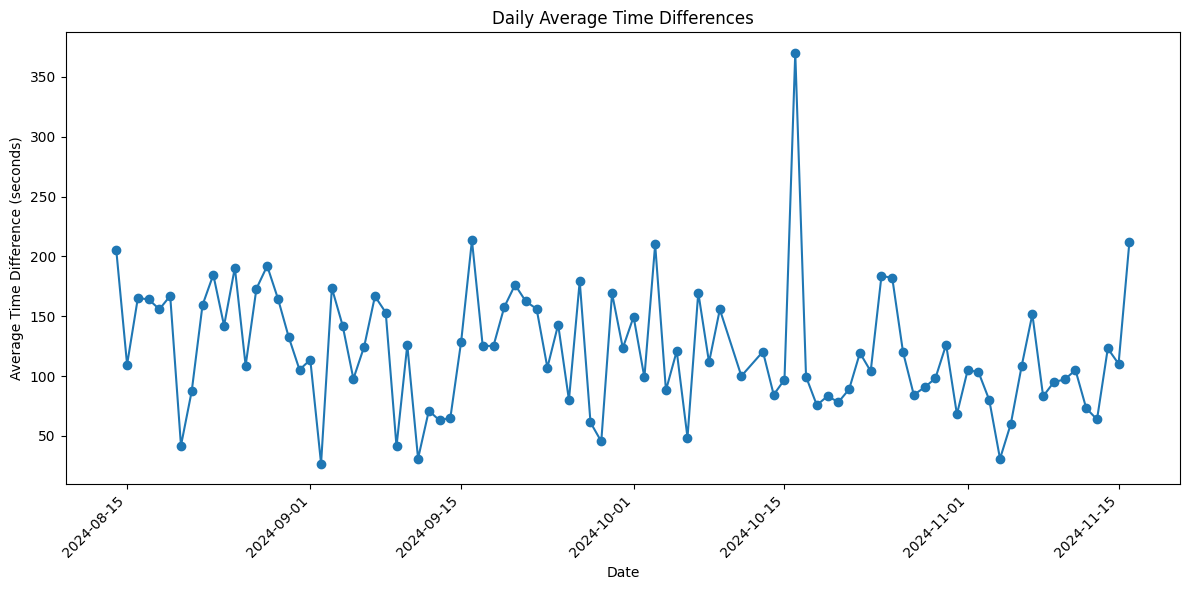

In [66]:
# This didn't really tell me anything, whatver it is is used throughout the whole day
plt.figure(figsize=(12, 6))
average_diffs_per_day.plot(kind='line', marker='o')
plt.xlabel("Date")
plt.ylabel("Average Time Difference (seconds)")
plt.title("Daily Average Time Differences")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Based on the intervals between timestamps (being about 2-3 minutes) and the behavior on the top days of having steady timestamp data over several hours, and then periods of "skipping" through the timestamps, my best guess is this data is from some sort of music streaming app. The timestamp duration is my biggest clue - by taking out the time when the app wasn't in use, it's very consistent at about the duration of a song, and then the periods of skipping songs on a playlist or radio.